# Sagemaker 

## Transformar los datos y entrenar un modelo dentro de un notebook Jupyter.




En este notebook demostraremos un viaje hacia el aprendizaje automático nativo en la nube, empezando por un enfoque más tradicional de desarrollo de modelos y entrenamiento directamente en notebooks Jupyter, pasando por transformaciones de datos gestionadas de forma remota y entrenamiento con Amazon SageMaker, hasta pipelines totalmente automatizados con [SageMaker Pipelines](https://aws.amazon.com/sagemaker/pipelines/).

En este primer cuaderno predeciremos el precio de la vivienda basándonos en el conocido [Boston Housing dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) con un modelo de regresión simple en Tensorflow 2. Este Dataset público contiene 13 features relativas al parque de viviendas de las ciudades del área de Boston. Las features incluyen el número medio de habitaciones, la accesibilidad a las carreteras radiales, la adyacencia a un río importante, etc.  

Para empezar, crearemos directorios para los datos de entrenamiento y de prueba.  También configuraremos una sesión de SageMaker para realizar varias operaciones, y especificaremos un cubo de Amazon S3 para mantener los datos de entrada y salida.  El cubo por defecto utilizado aquí es creado por SageMaker si no existe ya, y nombrado de acuerdo con el ID de la cuenta de AWS y la región de AWS.  

!pip install matplotlib seaborn

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
import os

data_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(data_dir, exist_ok=True)

train_dir = os.path.join(os.getcwd(), 'data/train')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(os.getcwd(), 'data/test')
os.makedirs(test_dir, exist_ok=True)

raw_dir = os.path.join(os.getcwd(), 'data/raw')
os.makedirs(raw_dir, exist_ok=True)

batch_dir = os.path.join(os.getcwd(), 'data/batch')
os.makedirs(batch_dir, exist_ok=True)

# Exploratory Data Analysis (EDA)

According to The [State of Data Science 2020](https://www.anaconda.com/state-of-data-science-2020) survey, data management, exploratory data analysis (EDA), feature selection, and feature engineering accounts for more than 66% of a data scientist’s time.

Exploratory Data Analysis is an approach in analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods.
EDA assists Data science professionals in various ways:-

- Getting a better understanding of data.
- Identifying various data patterns.
- Getting a better understanding of the problem statement.

Numerical EDA gives you some very important information, such as the names and data types of the columns, and the dimensions of the DataFrame. 
Visual EDA on the other hand will give you insight into features and target relationship and distribution.

First we'll load the Boston Housing dataset and explore the data.

Según la encuesta [State of Data Science 2020](https://www.anaconda.com/state-of-data-science-2020), la gestión de datos, el análisis exploratorio de datos (EDA), la selección de features y la ingeniería de features representan más del 66% del tiempo de un científico de datos.

El análisis exploratorio de datos es un enfoque para analizar Datasets con el fin de resumir sus principales características, a menudo utilizando gráficos estadísticos y otros métodos de visualización de datos.
El EDA ayuda a los profesionales de la ciencia de los datos de varias maneras

- Obtener una mejor comprensión de los datos.
- Identificar patrones en los datos.
- Obtener una mejor comprensión del planteamiento del problema.

El EDA numérico da información muy importante, como los nombres y tipos de datos de las columnas, y las dimensiones del DataFrame.
El EDA visual, por otro lado, da una visión de la relación entre las features y el target y de la distribución de las muestras.


Primero cargaremos el Dataset de viviendas de Boston y exploraremos los datos.

In [5]:
from tensorflow.python.keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

57344/57026 [==============================] - 0s 0us/step
(404, 13) (404,)
(102, 13) (102,)


In [6]:
columns=['CRIM',
         'ZN',
         'INDUS',
         'CHAS',
         'NOX',
         'RM',
         'AGE',
         'DIS',
         'RAD',
         'TAX',
         'PTRATIO',
         'B',
         'LSTAT']

df = pd.DataFrame(x_train, columns=columns)
df["MEDV"] = y_train
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,1.23247,0.0,8.14,0.0,0.5380,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.4150,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.6310,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.5150,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.7130,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.21977,0.0,6.91,0.0,0.4480,5.602,62.0,6.0877,3.0,233.0,17.9,396.90,16.20,19.4
400,0.16211,20.0,6.96,0.0,0.4640,6.240,16.3,4.4290,3.0,223.0,18.6,396.90,6.59,25.2
401,0.03466,35.0,6.06,0.0,0.4379,6.031,23.3,6.6407,1.0,304.0,16.9,362.25,7.83,19.4
402,2.14918,0.0,19.58,0.0,0.8710,5.709,98.5,1.6232,5.0,403.0,14.7,261.95,15.79,19.4


### EDA numérico

Comprobamos qué tamaño tiene el Dataset, cuántas features tiene y de qué tipo, y cuál es el target.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     404 non-null    float64
 1   ZN       404 non-null    float64
 2   INDUS    404 non-null    float64
 3   CHAS     404 non-null    float64
 4   NOX      404 non-null    float64
 5   RM       404 non-null    float64
 6   AGE      404 non-null    float64
 7   DIS      404 non-null    float64
 8   RAD      404 non-null    float64
 9   TAX      404 non-null    float64
 10  PTRATIO  404 non-null    float64
 11  B        404 non-null    float64
 12  LSTAT    404 non-null    float64
 13  MEDV     404 non-null    float64
dtypes: float64(14)
memory usage: 44.3 KB


Hay 14 atributos en cada caso del Dataset:

1. CRIM - tasa de criminalidad per cápita por ciudad.
2. ZN - proporción de terrenos residenciales agrupados en solares de más de 25.000 pies cuadrados.
3. INDUS - proporción de acres comerciales no minoristas por ciudad.
4. CHAS - Variable ficticia del río Charles (1 si el tramo limita con el río; 0 en caso contrario).
5. NOX - concentración de óxidos nítricos (partes por 10 millones).
6. RM - número medio de habitaciones por vivienda.
7. EDAD - proporción de unidades habitadas por sus propietarios construidas antes de 1940.
8. DIS - distancias ponderadas a cinco centros de empleo de Boston.
9. RAD - índice de accesibilidad a las autopistas radiales.
10. TAX - tasa de impuesto sobre el valor total de la propiedad por cada 10.000 dólares.
11. PTRATIO - ratio alumno-profesor por ciudad.
12. B - 1000(Bk - 0.63)^2 donde Bk es la proporción de gente de color por ciudad.
13. LSTAT - % de estatus inferior de la población.
14. MEDV - Valor medio de las viviendas habitadas por sus propietarios.

Ahora, vamos a resumir los datos para ver la distribución de los mismos

In [8]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817,22.395050
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545,9.210442
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000,16.675000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000,20.750000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500,24.800000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### EDA visual

Intentemos encontrar el nivel de delincuencia en relación con la condición de ciudadano y el valor medio de las viviendas.

In [9]:
df['medv_bins'] = pd.cut(df.MEDV, bins=5, include_lowest=True)
df.medv_bins.head()

0    (14.0, 23.0]
1    (41.0, 50.0]
2    (41.0, 50.0]
3    (14.0, 23.0]
4    (14.0, 23.0]
Name: medv_bins, dtype: category
Categories (5, interval[float64]): [(4.954, 14.0] < (14.0, 23.0] < (23.0, 32.0] < (32.0, 41.0] < (41.0, 50.0]]

In [10]:
df['lstat_bins'] = pd.cut(df.LSTAT, bins=[0, 7, 17, 38], labels=['richest', 'ordinary', 'poorest'], include_lowest=True)
df.lstat_bins.head()

0     poorest
1     richest
2     richest
3    ordinary
4    ordinary
Name: lstat_bins, dtype: category
Categories (3, object): ['richest' < 'ordinary' < 'poorest']

[Text(0.5, 147.10363636363638, '')]

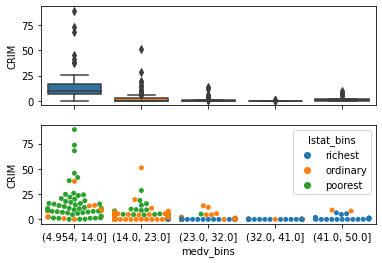

In [11]:
f, (ax_viol, ax_box) = plt.subplots(2, sharex=True)

sns.boxplot(x='medv_bins', y='CRIM', data=df, ax=ax_viol)
sns.swarmplot(x='medv_bins', y='CRIM', hue='lstat_bins', data=df, ax=ax_box)

ax_viol.set(xlabel='')

Podemos ver que a medida que el estatus de los ciudadanos es más pobre (LSTAT) y el valor medio de las casas es más bajo (MEDV), el nivel de delincuencia está creciendo (CRIM).

# Dataset transformation <a class="anchor" id="SageMakerProcessing">


A continuación, transformaremos el Dataset. En un flujo de trabajo típico de SageMaker, los notebooks sólo se utilizan para la creación de prototipos y pueden ejecutarse en instancias relativamente baratas y menos potentes, mientras que las tareas de procesamiento, formación y alojamiento de modelos se ejecutan en instancias independientes y más potentes gestionadas por SageMaker.



Ahora guardaremos los datos de features en bruto, y también guardaremos las etiquetas para el entrenamiento y las pruebas.

In [12]:
import numpy as np
from sklearn.preprocessing import StandardScaler

np.save(os.path.join(raw_dir, 'x_train.npy'), x_train)
np.save(os.path.join(raw_dir, 'x_test.npy'), x_test)
np.save(os.path.join(raw_dir, 'y_train.npy'), y_train)
np.save(os.path.join(raw_dir, 'y_test.npy'), y_test)

A continuación, ejecutaremos el preprocesamiento de datos como se muestra a continuación.

In [13]:
import glob
import numpy as np
import os
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
x_train = np.load(os.path.join(raw_dir, 'x_train.npy'))
scaler.fit(x_train)

StandardScaler()

In [14]:
input_files = glob.glob('{}/raw/*.npy'.format(data_dir))
print('\nINPUT FILE LIST: \n{}\n'.format(input_files))
for file in input_files:
    raw = np.load(file)
    # only transform feature columns
    if 'y_' not in file:
        transformed = scaler.transform(raw)
    if 'train' in file:
        if 'y_' in file:
            output_path = os.path.join(train_dir, 'y_train.npy')
            np.save(output_path, raw)
            print('SAVED LABEL TRAINING DATA FILE\n')
        else:
            output_path = os.path.join(train_dir, 'x_train.npy')
            np.save(output_path, transformed)
            print('SAVED TRANSFORMED TRAINING DATA FILE\n')
    else:
        if 'y_' in file:
            output_path = os.path.join(test_dir, 'y_test.npy')
            np.save(output_path, raw)
            print('SAVED LABEL TEST DATA FILE\n')
        else:
            output_path = os.path.join(test_dir, 'x_test.npy')
            np.save(output_path, transformed)
            print('SAVED TRANSFORMED TEST DATA FILE\n')


INPUT FILE LIST: 
['/root/curso-mlops/modulo7-mlops-y-cloud-computing/notebooks/data/raw/x_test.npy', '/root/curso-mlops/modulo7-mlops-y-cloud-computing/notebooks/data/raw/x_train.npy', '/root/curso-mlops/modulo7-mlops-y-cloud-computing/notebooks/data/raw/y_test.npy', '/root/curso-mlops/modulo7-mlops-y-cloud-computing/notebooks/data/raw/y_train.npy']

SAVED TRANSFORMED TEST DATA FILE

SAVED TRANSFORMED TRAINING DATA FILE

SAVED LABEL TEST DATA FILE

SAVED LABEL TRAINING DATA FILE



#  Training <a class="anchor" id="SageMakerHostedTraining">


Ahora que hemos preparado un conjunto de datos, podemos pasar al entrenamiento del modelo.

In [15]:
import numpy as np
import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

def get_train_data(train_dir):
    x_train = np.load(os.path.join(train_dir, 'x_train.npy'))
    y_train = np.load(os.path.join(train_dir, 'y_train.npy'))
    print('x train', x_train.shape,'y train', y_train.shape)

    return x_train, y_train


def get_test_data(test_dir):
    x_test = np.load(os.path.join(test_dir, 'x_test.npy'))
    y_test = np.load(os.path.join(test_dir, 'y_test.npy'))
    print('x test', x_test.shape,'y test', y_test.shape)

    return x_test, y_test

def get_model():
    inputs = tf.keras.Input(shape=(13,))
    hidden_1 = tf.keras.layers.Dense(13, activation='tanh')(inputs)
    hidden_2 = tf.keras.layers.Dense(6, activation='sigmoid')(hidden_1)
    outputs = tf.keras.layers.Dense(1)(hidden_2)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [16]:
x_train, y_train = get_train_data(train_dir)
x_test, y_test = get_test_data(test_dir)

device = '/cpu:0'
print(device)
batch_size = 128
epochs = 80
learning_rate = 0.01
print('batch_size = {}, epochs = {}, learning rate = {}'.format(batch_size, epochs, learning_rate))

with tf.device(device):
    model = get_model()
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
              validation_data=(x_test, y_test))

    # evaluar en el Dataset
    scores = model.evaluate(x_test, y_test, batch_size, verbose=2)
    print("\nTest MSE :", scores)


x train (404, 13) y train (404,)
x test (102, 13) y test (102,)
/cpu:0
batch_size = 128, epochs = 80, learning rate = 0.01
[2022-11-15 21:05:50.270 tensorflow-2-3-cpu-py-ml-t3-medium-dbca98283d57d615662c4efa28c8:65 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-15 21:05:50.544 tensorflow-2-3-cpu-py-ml-t3-medium-dbca98283d57d615662c4efa28c8:65 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Epoch 1/80
4/4 [==============================] - 0s 50ms/step - loss: 523.8408 - val_loss: 409.4091
Epoch 2/80
4/4 [==============================] - 0s 12ms/step - loss: 340.5691 - val_loss: 240.6197
Epoch 3/80
4/4 [==============================] - 0s 11ms/step - loss: 195.0746 - val_loss: 136.6693
Epoch 4/80
4/4 [==============================] - 0s 11ms/step - loss: 114.6293 - val_loss: 92.8787
Epoch 5/80
4/4 [==============================] - 0s 11ms/step - loss: 82.9420 - val_loss: 70.0941
Epoch 6/80
4

El archivo descomprimido debe incluir los activos requeridos por TensorFlow Serving para cargar el modelo y servirlo, incluyendo un archivo .pb:  

In [17]:
model.save('model' + '/1')

# Puntuación del modelo

In [18]:
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model('model/1')

x_test = np.load(os.path.join(test_dir, 'x_test.npy'))
y_test = np.load(os.path.join(test_dir, 'y_test.npy'))
scores = model.evaluate(x_test, y_test, verbose=2)
print("\nTest MSE :", scores)

4/4 - 0s - loss: 17.5506

Test MSE : 17.550594329833984
